In [1]:
import umap
from sklearn.cluster import DBSCAN
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor, plot_tree
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV
from decision_tree import DecisionTree

D:\5-sem-ml-labs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### датасет состоит из игр
#### таргет - % положительных отзывов
#### модель - дерево решений

In [2]:
data = pd.read_csv("data.csv")
data

,id,price,date,ram,hdd,reviews_30,reviews_all,Action,Adventure,RPG,Strategy,Simulation,Casual,Puzzle,Sports,Racing,Horror
0,1,9.99,9.730260e+08,96,0.0,0.95,0.96,1,0,0,0,0,0,0,0,0,0
1,2,19.99,1.602623e+09,4096,1200.0,0.85,0.93,1,0,0,1,1,0,0,0,0,0
2,3,19.99,1.613423e+09,8192,16384.0,0.80,0.89,1,0,0,0,0,0,0,0,0,0
3,4,19.99,1.567717e+09,4096,12288.0,0.00,0.55,0,0,0,0,1,0,0,1,0,0
4,5,4.99,1.574802e+09,4096,12288.0,0.00,0.66,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9838,9839,15.99,1.576098e+09,8192,150.0,0.89,0.89,0,0,0,0,1,0,0,0,0,0
9839,9840,19.99,1.717016e+09,8192,41984.0,0.88,0.91,1,1,0,0,1,1,0,0,0,0
9840,9841,19.99,1.602709e+09,4096,1024.0,0.87,0.93,0,0,0,1,0,0,0,0,0,0
9841,9842,29.99,1.582578e+09,2048,7168.0,1.00,0.79,1,0,1,0,0,0,0,0,0,0


убираю выбросы и невалидные значения

In [3]:
df = data[(data["price"] != -1) & (data["reviews_all"] != 0.0) & (data["hdd"] != 0.0) & (
        data["ram"] != 0.0) & (data["date"] != -1)].copy()

now = datetime.now().year
df["date"] = now - pd.to_datetime(df["date"], unit='s').dt.year
df["ram"] = df["ram"] / 1024
df["hdd"] = df["hdd"] / 1024

for col in ["price", "ram", "hdd", "date"]:
    limit = df[col].quantile(0.97)
    df = df[df[col] < limit]

df = df.drop(columns=["Horror", "Puzzle", "id", "reviews_30"])

df

,price,date,ram,hdd,reviews_all,Action,Adventure,RPG,Strategy,Simulation,Casual,Sports,Racing
1,19.99,5,4.0,1.171875,0.93,1,0,0,1,1,0,0,0
2,19.99,4,8.0,16.000000,0.89,1,0,0,0,0,0,0,0
3,19.99,6,4.0,12.000000,0.55,0,0,0,0,1,0,1,0
4,4.99,6,4.0,12.000000,0.66,0,0,0,0,1,0,1,0
5,4.99,6,4.0,12.000000,0.87,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9838,15.99,6,8.0,0.146484,0.89,0,0,0,0,1,0,0,0
9839,19.99,1,8.0,41.000000,0.91,1,1,0,0,1,1,0,0
9840,19.99,5,4.0,1.000000,0.93,0,0,0,1,0,0,0,0
9841,29.99,5,2.0,7.000000,0.79,1,0,1,0,0,0,0,0


немножко графиков

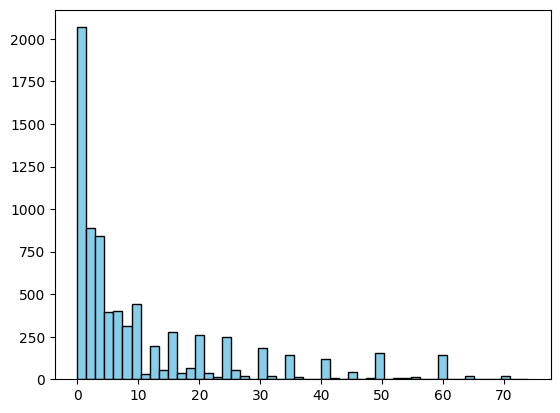

In [11]:
plt.hist(df["hdd"], bins=50, color='skyblue', edgecolor='black')
plt.show()

In [5]:
X = df.drop(columns=["reviews_all"])
umap_2d = umap.UMAP(n_components=2)
x_umap = umap_2d.fit_transform(X)

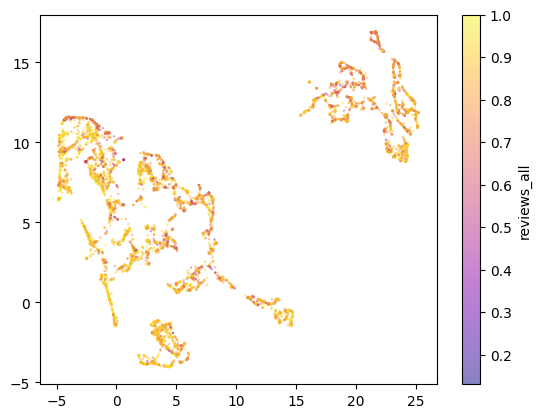

In [7]:
plt.scatter(x_umap[:, 0], x_umap[:, 1], c=df["reviews_all"], cmap='plasma', s=3, alpha=0.5, edgecolors='none')
plt.colorbar(label='reviews_all')
plt.show()

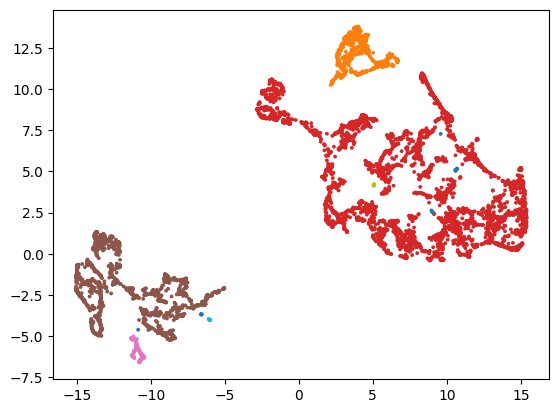

In [35]:
labels = DBSCAN(eps=0.5, min_samples=10).fit_predict(x_umap)
plt.scatter(x_umap[:, 0], x_umap[:, 1], c=labels, cmap='tab10', s=3)
plt.show()

In [15]:
df.corr()['reviews_all']

price          0.020316
date           0.002940
ram           -0.157233
hdd           -0.245095
reviews_all    1.000000
Action         0.045396
Adventure      0.090653
RPG            0.004906
Strategy      -0.145234
Simulation    -0.160437
Casual         0.083714
Sports        -0.020852
Racing         0.009178
Name: reviews_all, dtype: float64

подбор гиперпараметров

In [27]:
X = df.drop(columns=["reviews_all"])
y = df["reviews_all"]
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25)

r_square = []
for md in range(1, 15):
    for msl in range(10, 150):
        tree_model = DecisionTreeRegressor(max_depth=md, min_samples_leaf=msl)
        tree_model.fit(X_train, y_train)

        y_pred = tree_model.predict(X_val)
        r2 = r2_score(y_val, y_pred)
        mape = mean_absolute_percentage_error(y_val, y_pred)
        r_square.append((r2, mape, md, msl))

max(r_square, key=lambda x: x[0])

(0.17677660211232638, 0.12098204786845759, 7, 11)

In [12]:
md = [x for x in range(1, 15)]
msl = [x for x in range(5, 150)]
params = {"max_depth": md, "min_samples_leaf": msl}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
grid = GridSearchCV(
    DecisionTreeRegressor(),
    param_grid=params,
    scoring="r2",
    cv=5,
    n_jobs=-1
)
grid.fit(X_train, y_train)

print(grid.best_params_, grid.best_score_)

{'max_depth': 7, 'min_samples_leaf': 50} 0.1737049621221914


In [29]:
tree_model = DecisionTreeRegressor(max_depth=7, min_samples_leaf=14)
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"test: {r2} {mape}")

y_pred_train = tree_model.predict(X_train)

r2_train = r2_score(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
print(f"train: {r2_train} {mape_train}")

test: 0.15034774604965262 0.12159632231763312
train: 0.2568782662222111 0.12320240977263684


[Text(0.5, 0.8333333333333334, 'x[3] <= 5.25\nsquared_error = 0.017\nsamples = 6055\nvalue = 0.822'),
 Text(0.25, 0.5, 'x[0] <= 0.245\nsquared_error = 0.014\nsamples = 3334\nvalue = 0.852'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'x[3] <= 32.75\nsquared_error = 0.019\nsamples = 2721\nvalue = 0.785'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

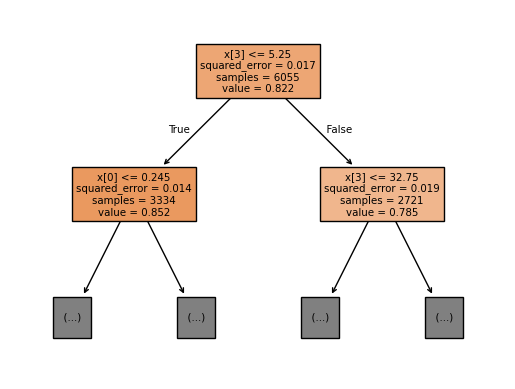

In [28]:
plot_tree(tree_model, filled=True, max_depth=1)

Подбор гиперпараметров у моего дерева

In [16]:
X = df.drop(columns=["reviews_all"])
y = df["reviews_all"]
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25)

r_square = []
for md in range(3, 12):
    for msl in range(5, 150, 5):
        tree_model = DecisionTree()
        tree_model.fit(X_train, y_train, max_depth=md, min_samples=msl)

        y_pred = tree_model.predict(X_val)
        r2 = r2_score(y_val, y_pred)
        mape = mean_absolute_percentage_error(y_val, y_pred)
        r_square.append((r2, mape, md, msl))

max(r_square)

(0.1665658848452457, 0.12699075363671758, 7, 70)

In [17]:
my_tree = DecisionTree()
my_tree.fit(X_train, y_train, max_depth=7, min_samples=70)

y_pred = my_tree.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

y_pred_train = my_tree.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print(f"test: {r2} {mape}")
print(f"train: {r2_train} {mape_train}")

test: 0.15697826258838365 0.13025603744202674
train: 0.2113596578911765 0.12394623951597435


# сравнение метрик моделей:

## sklearn:
####    train R^2=0.2575321740202722 mape=0.12027548321590227
####    val  R^2=0.16281986041908492 mape=0.12756291540194323
####    test R^2=0.15383261604175247 mape=0.12523492005128717

## моя модель:
####    train R^2=0.2113596578911765 mape=0.12394623951597435
####    val  R^2=0.1665658848452457 mape=0.12699075363671758
####    test R^2=0.15697826258838365 mape=0.13025603744202674

выглядит похоже но R^2 довольно низкий
попробую увеличить глубину дерева

In [45]:
my_tree = DecisionTree()
my_tree.fit(X_train, y_train, max_depth=8, min_samples=30)

y_pred = my_tree.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

y_pred_train = my_tree.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print(f"test: {r2} {mape}")
print(f"train: {r2_train} {mape_train}")

test: 0.14847084320884263 0.12219297521537667
train: 0.24767479409503357 0.12402156284750439


In [46]:
my_tree = DecisionTree()
my_tree.fit(X_train, y_train, max_depth=10, min_samples=20)

y_pred = my_tree.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

y_pred_train = my_tree.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print(f"test: {r2} {mape}")
print(f"train: {r2_train} {mape_train}")

test: 0.15188751745304863 0.12163698930259885
train: 0.2965946083944372 0.11836732176879099


In [47]:
my_tree = DecisionTree()
my_tree.fit(X_train, y_train, max_depth=10, min_samples=10)

y_pred = my_tree.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

y_pred_train = my_tree.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print(f"test: {r2} {mape}")
print(f"train: {r2_train} {mape_train}")

test: 0.10951706564277741 0.1239757377320056
train: 0.33919414039650186 0.11495982193577739


## видно что при увеличении глубины R^2 на тренировочной выборке увеличивается а на тестовой уменьшается, что говорит о переобучении